In [1]:
#Author     : Fan Li
#Update Date: 03/12/2022
#Version    : 3.0

#Intrusion Detection System Using Machine Learning (CatBoost)

#Original Data (cic ids 2017)

#Borderline SMOTE)

#hardware
#12vCPUs | 48GiB | c7.3xlarge.4

#System
#Ubuntu 20.04 server 64bit

In [2]:
#1. Loading Module
#basic
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
import gc    #memory manage

import math
import numpy as np
import pandas as pd

#draw figure
import seaborn as sns
import matplotlib.pyplot as plt

#preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from collections import Counter

#Feature Selection

from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#model
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier

#metrics

from sklearn import model_selection,feature_selection,utils,ensemble,metrics
from catboost import CatBoostClassifier

#over-sampling and under sampling
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE,ADASYN,BorderlineSMOTE

#time
from time import time
import datetime

In [3]:
#2. Reading Dataset
base_path="../../data/"
# Monday benign
f1_path=base_path+"Monday-WorkingHours.pcap_ISCX.csv"
f1=pd.read_csv(f1_path)
#Tuesday benign
f2_path=base_path+"Tuesday-WorkingHours.pcap_ISCX.csv"
f2=pd.read_csv(f2_path)
#Wed benign
f3_path=base_path+"Wednesday-workingHours.pcap_ISCX.csv"
f3=pd.read_csv(f3_path)
#Thur WebAttack
f4_path1=base_path+"Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv"
f41=pd.read_csv(f4_path1)
f4_path2=base_path+"Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv"
f42=pd.read_csv(f4_path2)
#Fri Benign DDos PortScan
f5_path1=base_path+"Friday-WorkingHours-Morning.pcap_ISCX.csv"
f51=pd.read_csv(f5_path1)

f5_path2=base_path+"Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv"
f52=pd.read_csv(f5_path2)

f5_path3=base_path+"Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"
f53=pd.read_csv(f5_path3)

In [4]:
data=pd.concat((f1,f2,f3,f41,f42,f51,f52,f53))
data.reset_index(inplace=True,drop=True) # duplicate index exist, reset index
data.shape

(2830743, 79)

In [5]:
data

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,49188,4,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,49486,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830738,61374,61,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830739,61378,72,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830740,61375,75,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830741,61323,48,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [6]:
# too few samples in some subclasses of Web Attack, and they are combined into one class.
#Tuesday Brute Force
data[' Label'].replace("FTP-Patator","BruteForce",inplace=True,regex=True)
data[' Label'].replace("SSH-Patator","BruteForce",inplace=True,regex=True)
#Thursday Web Attack
data[' Label'].replace("Web Attack .*","Web Attack",inplace=True,regex=True)
#DoS 
data[' Label'].replace("DoS .*","DoS",inplace=True,regex=True)
data[' Label'].replace("DDoS","DoS",inplace=True,regex=True)

In [7]:
target_count_new=data[' Label'].value_counts(0)
target_count_new

BENIGN          2273097
DoS              380688
PortScan         158930
BruteForce        13835
Web Attack         2180
Bot                1966
Infiltration         36
Heartbleed           11
Name:  Label, dtype: int64

In [8]:
labels_new,values_new=zip(*sorted(target_count_new.items()))

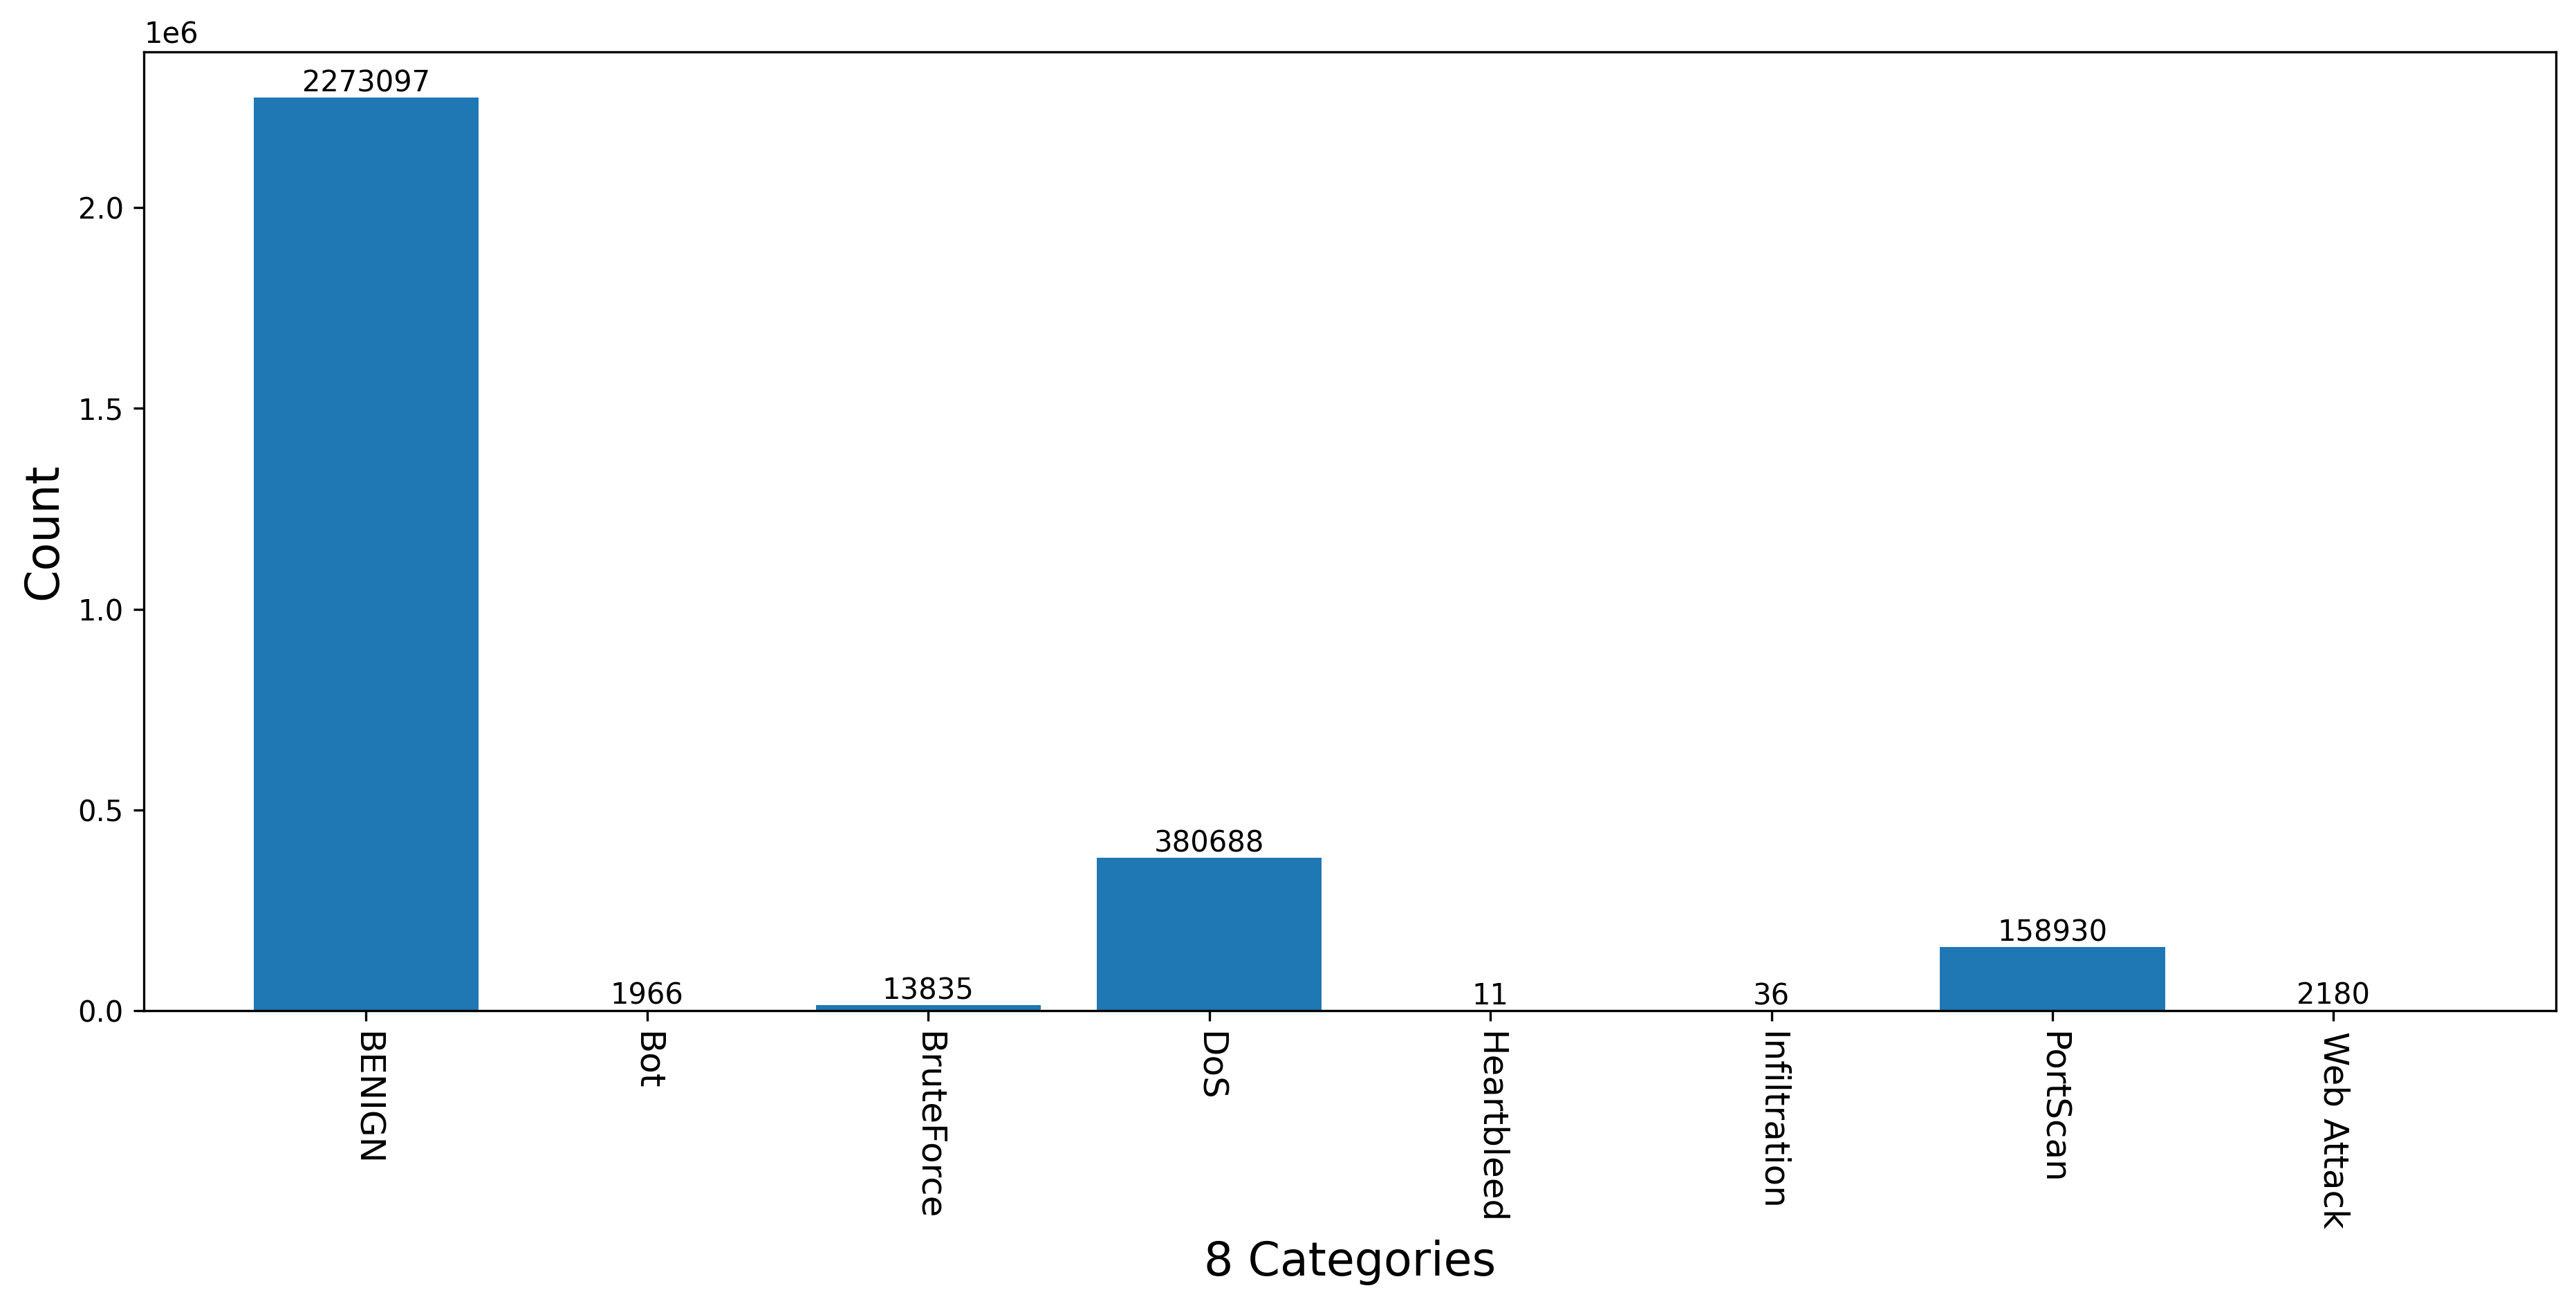

In [9]:
plt.figure(dpi=300,figsize=(15,6))
plt.bar(labels_new,values_new)
for x_new,y_new in zip(labels_new,values_new):
    plt.text(x_new,y_new,y_new,ha="center",va="bottom")
plt.xticks(fontsize=12,rotation=-90)
plt.xlabel("8 Categories",fontsize=16)
plt.ylabel("Count",fontsize=16)
plt.show()

In [10]:
#3. Preprocessing
#3.1 remove useless data
#remove duplicate row
data=data.drop_duplicates()
#remove rows with null value and infinite value
data=data.replace(np.inf,np.nan)
data=data.dropna()

In [11]:
data[' Label'].value_counts()

BENIGN          2072476
DoS              321759
PortScan          90694
BruteForce         9150
Web Attack         2143
Bot                1948
Infiltration         36
Heartbleed           11
Name:  Label, dtype: int64

In [12]:
X=data.iloc[:,:-1]
y=data.iloc[:,-1]
print(Counter(y))

Counter({'BENIGN': 2072476, 'DoS': 321759, 'PortScan': 90694, 'BruteForce': 9150, 'Web Attack': 2143, 'Bot': 1948, 'Infiltration': 36, 'Heartbleed': 11})


In [13]:
#Label Encoding
le=LabelEncoder()
le=le.fit(y)
le.classes_
y=le.transform(y)
print(Counter(y))

Counter({0: 2072476, 3: 321759, 6: 90694, 2: 9150, 7: 2143, 1: 1948, 5: 36, 4: 11})


In [14]:
#Ram Clean
del data
gc.collect()

3692

In [15]:
#3.2 Splitting data
X_train,X_test,y_train,y_test=model_selection.train_test_split(X,y,test_size=0.33,random_state=123456)

In [16]:
print(Counter(y_train))

Counter({0: 1388615, 3: 215467, 6: 60860, 2: 6100, 7: 1440, 1: 1293, 5: 20, 4: 10})


In [17]:
#3.3 SMOTE
time0=time()
bsm=BorderlineSMOTE(k_neighbors=9,random_state=42,kind='borderline-2',n_jobs=-1)
X_train,y_train=bsm.fit_resample(X_train,y_train)

In [18]:
print("Time of BorderlineSMOTE : {:.3f} s".format(time()-time0))

Time of BorderlineSMOTE : 523.574 s


In [19]:
print(Counter(y_train))

Counter({0: 1388615, 3: 1388615, 1: 1388615, 4: 1388615, 6: 1388614, 2: 1388614, 7: 1388614, 5: 1388614})


In [20]:
#4. Training
clf=CatBoostClassifier(random_state=12345)

In [21]:
time1=time()
clf.fit(X_train,y_train)
print("Time of Training : {:.3f} s".format(time()-time1))

Learning rate set to 0.127248
0:	learn: 1.5248960	total: 3.89s	remaining: 1h 4m 47s
1:	learn: 1.2901178	total: 7.62s	remaining: 1h 3m 23s
2:	learn: 1.1256444	total: 11.3s	remaining: 1h 2m 49s
3:	learn: 0.9905344	total: 15.3s	remaining: 1h 3m 37s
4:	learn: 0.8945834	total: 18.7s	remaining: 1h 1m 59s
5:	learn: 0.8068611	total: 22.5s	remaining: 1h 2m 7s
6:	learn: 0.7355726	total: 26.6s	remaining: 1h 2m 47s
7:	learn: 0.6794336	total: 29.9s	remaining: 1h 1m 51s
8:	learn: 0.6313876	total: 33.5s	remaining: 1h 1m 28s
9:	learn: 0.5867957	total: 37.5s	remaining: 1h 1m 49s
10:	learn: 0.5519105	total: 40.7s	remaining: 1h 59s
11:	learn: 0.5155876	total: 45s	remaining: 1h 1m 46s
12:	learn: 0.4801987	total: 49.1s	remaining: 1h 2m 10s
13:	learn: 0.4500982	total: 53s	remaining: 1h 2m 12s
14:	learn: 0.4244931	total: 56.9s	remaining: 1h 2m 17s
15:	learn: 0.4007575	total: 1m	remaining: 1h 2m 26s
16:	learn: 0.3780639	total: 1m 4s	remaining: 1h 2m 32s
17:	learn: 0.3626554	total: 1m 8s	remaining: 1h 2m 2s
18

152:	learn: 0.0395837	total: 9m 28s	remaining: 52m 25s
153:	learn: 0.0393218	total: 9m 31s	remaining: 52m 20s
154:	learn: 0.0390691	total: 9m 35s	remaining: 52m 16s
155:	learn: 0.0389126	total: 9m 38s	remaining: 52m 9s
156:	learn: 0.0387371	total: 9m 41s	remaining: 52m 4s
157:	learn: 0.0384960	total: 9m 45s	remaining: 51m 59s
158:	learn: 0.0383398	total: 9m 48s	remaining: 51m 50s
159:	learn: 0.0380428	total: 9m 52s	remaining: 51m 49s
160:	learn: 0.0377690	total: 9m 55s	remaining: 51m 44s
161:	learn: 0.0374768	total: 9m 59s	remaining: 51m 42s
162:	learn: 0.0372244	total: 10m 2s	remaining: 51m 33s
163:	learn: 0.0368477	total: 10m 6s	remaining: 51m 30s
164:	learn: 0.0365927	total: 10m 10s	remaining: 51m 29s
165:	learn: 0.0363663	total: 10m 14s	remaining: 51m 26s
166:	learn: 0.0361297	total: 10m 17s	remaining: 51m 21s
167:	learn: 0.0358383	total: 10m 22s	remaining: 51m 20s
168:	learn: 0.0356686	total: 10m 25s	remaining: 51m 17s
169:	learn: 0.0354097	total: 10m 29s	remaining: 51m 13s
170:	l

300:	learn: 0.0174331	total: 18m 35s	remaining: 43m 10s
301:	learn: 0.0172678	total: 18m 39s	remaining: 43m 7s
302:	learn: 0.0171965	total: 18m 43s	remaining: 43m 3s
303:	learn: 0.0171699	total: 18m 45s	remaining: 42m 56s
304:	learn: 0.0170774	total: 18m 48s	remaining: 42m 51s
305:	learn: 0.0170078	total: 18m 52s	remaining: 42m 48s
306:	learn: 0.0169566	total: 18m 56s	remaining: 42m 44s
307:	learn: 0.0168720	total: 18m 59s	remaining: 42m 41s
308:	learn: 0.0167455	total: 19m 4s	remaining: 42m 39s
309:	learn: 0.0166483	total: 19m 8s	remaining: 42m 37s
310:	learn: 0.0166036	total: 19m 11s	remaining: 42m 32s
311:	learn: 0.0165640	total: 19m 15s	remaining: 42m 27s
312:	learn: 0.0165063	total: 19m 18s	remaining: 42m 23s
313:	learn: 0.0164432	total: 19m 22s	remaining: 42m 20s
314:	learn: 0.0164125	total: 19m 25s	remaining: 42m 15s
315:	learn: 0.0163576	total: 19m 28s	remaining: 42m 9s
316:	learn: 0.0162924	total: 19m 32s	remaining: 42m 5s
317:	learn: 0.0162171	total: 19m 35s	remaining: 42m
31

448:	learn: 0.0104194	total: 27m 33s	remaining: 33m 49s
449:	learn: 0.0103977	total: 27m 36s	remaining: 33m 44s
450:	learn: 0.0103714	total: 27m 40s	remaining: 33m 41s
451:	learn: 0.0103459	total: 27m 43s	remaining: 33m 37s
452:	learn: 0.0103273	total: 27m 46s	remaining: 33m 32s
453:	learn: 0.0102950	total: 27m 51s	remaining: 33m 29s
454:	learn: 0.0102583	total: 27m 55s	remaining: 33m 26s
455:	learn: 0.0102363	total: 27m 58s	remaining: 33m 22s
456:	learn: 0.0102027	total: 28m 2s	remaining: 33m 19s
457:	learn: 0.0101738	total: 28m 6s	remaining: 33m 16s
458:	learn: 0.0101335	total: 28m 10s	remaining: 33m 12s
459:	learn: 0.0101145	total: 28m 14s	remaining: 33m 9s
460:	learn: 0.0100904	total: 28m 19s	remaining: 33m 6s
461:	learn: 0.0100589	total: 28m 23s	remaining: 33m 3s
462:	learn: 0.0100396	total: 28m 26s	remaining: 32m 58s
463:	learn: 0.0100112	total: 28m 30s	remaining: 32m 55s
464:	learn: 0.0100006	total: 28m 33s	remaining: 32m 50s
465:	learn: 0.0099724	total: 28m 36s	remaining: 32m 4

596:	learn: 0.0074027	total: 36m 24s	remaining: 24m 34s
597:	learn: 0.0073946	total: 36m 27s	remaining: 24m 30s
598:	learn: 0.0073769	total: 36m 30s	remaining: 24m 26s
599:	learn: 0.0073689	total: 36m 34s	remaining: 24m 23s
600:	learn: 0.0073561	total: 36m 38s	remaining: 24m 19s
601:	learn: 0.0073425	total: 36m 42s	remaining: 24m 16s
602:	learn: 0.0073270	total: 36m 46s	remaining: 24m 12s
603:	learn: 0.0073193	total: 36m 49s	remaining: 24m 8s
604:	learn: 0.0073144	total: 36m 52s	remaining: 24m 4s
605:	learn: 0.0072963	total: 36m 55s	remaining: 24m
606:	learn: 0.0072826	total: 36m 59s	remaining: 23m 56s
607:	learn: 0.0072650	total: 37m 2s	remaining: 23m 52s
608:	learn: 0.0072518	total: 37m 5s	remaining: 23m 49s
609:	learn: 0.0072388	total: 37m 8s	remaining: 23m 44s
610:	learn: 0.0072183	total: 37m 12s	remaining: 23m 41s
611:	learn: 0.0071963	total: 37m 16s	remaining: 23m 38s
612:	learn: 0.0071785	total: 37m 19s	remaining: 23m 33s
613:	learn: 0.0071561	total: 37m 23s	remaining: 23m 30s
6

744:	learn: 0.0057467	total: 45m 4s	remaining: 15m 25s
745:	learn: 0.0057402	total: 45m 8s	remaining: 15m 22s
746:	learn: 0.0057297	total: 45m 12s	remaining: 15m 18s
747:	learn: 0.0057101	total: 45m 17s	remaining: 15m 15s
748:	learn: 0.0057043	total: 45m 21s	remaining: 15m 11s
749:	learn: 0.0056959	total: 45m 24s	remaining: 15m 8s
750:	learn: 0.0056843	total: 45m 28s	remaining: 15m 4s
751:	learn: 0.0056732	total: 45m 31s	remaining: 15m
752:	learn: 0.0056301	total: 45m 34s	remaining: 14m 57s
753:	learn: 0.0056256	total: 45m 38s	remaining: 14m 53s
754:	learn: 0.0056162	total: 45m 41s	remaining: 14m 49s
755:	learn: 0.0056087	total: 45m 44s	remaining: 14m 45s
756:	learn: 0.0055992	total: 45m 47s	remaining: 14m 42s
757:	learn: 0.0055859	total: 45m 52s	remaining: 14m 38s
758:	learn: 0.0055741	total: 45m 56s	remaining: 14m 35s
759:	learn: 0.0055664	total: 46m	remaining: 14m 31s
760:	learn: 0.0055607	total: 46m 4s	remaining: 14m 28s
761:	learn: 0.0055563	total: 46m 7s	remaining: 14m 24s
762:	l

893:	learn: 0.0046758	total: 53m 38s	remaining: 6m 21s
894:	learn: 0.0046671	total: 53m 42s	remaining: 6m 18s
895:	learn: 0.0046646	total: 53m 45s	remaining: 6m 14s
896:	learn: 0.0046554	total: 53m 49s	remaining: 6m 10s
897:	learn: 0.0046477	total: 53m 53s	remaining: 6m 7s
898:	learn: 0.0046443	total: 53m 56s	remaining: 6m 3s
899:	learn: 0.0046413	total: 54m	remaining: 6m
900:	learn: 0.0046348	total: 54m 4s	remaining: 5m 56s
901:	learn: 0.0046332	total: 54m 7s	remaining: 5m 52s
902:	learn: 0.0046290	total: 54m 11s	remaining: 5m 49s
903:	learn: 0.0046234	total: 54m 14s	remaining: 5m 45s
904:	learn: 0.0046190	total: 54m 16s	remaining: 5m 41s
905:	learn: 0.0046146	total: 54m 20s	remaining: 5m 38s
906:	learn: 0.0046096	total: 54m 23s	remaining: 5m 34s
907:	learn: 0.0046081	total: 54m 27s	remaining: 5m 31s
908:	learn: 0.0046068	total: 54m 29s	remaining: 5m 27s
909:	learn: 0.0045983	total: 54m 34s	remaining: 5m 23s
910:	learn: 0.0045950	total: 54m 37s	remaining: 5m 20s
911:	learn: 0.0045924	

In [22]:
y_pred_train=clf.predict(X_train)
y_pred_test=clf.predict(X_test)

In [23]:
y_train_en=OneHotEncoder().fit_transform(pd.DataFrame(y_train)).toarray()

In [24]:
y_pred_train_en=OneHotEncoder().fit_transform(pd.DataFrame(y_pred_train)).toarray()

In [25]:
y_train_en,y_pred_train_en

(array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]]))

In [26]:
y_test_en=OneHotEncoder().fit_transform(pd.DataFrame(y_test)).toarray()

In [27]:
y_pred_test_en=OneHotEncoder().fit_transform(pd.DataFrame(y_pred_test)).toarray()

In [28]:
y_test_en,y_pred_test_en

(array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]),
 array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]))

In [29]:
#5. Result 
#5.1 Train
print("==Train==")
result=metrics.confusion_matrix(y_train,y_pred_train)
report=metrics.classification_report(y_train,y_pred_train,zero_division=1)

print(result)
print(report)

print("Accuracy Score = ",metrics.balanced_accuracy_score(y_train,y_pred_train))
print("Precison       = ",metrics.precision_score(y_train,y_pred_train,average='macro'))
print("Recall         = ",metrics.recall_score(y_train,y_pred_train,average='macro'))
print("F1_score       = ",metrics.f1_score(y_train,y_pred_train,average='macro'))
print("Auc score      = ",metrics.roc_auc_score(y_train_en,y_pred_train_en,average='macro'))

==Train==
[[1384903    1735      52    1194       0       1     633      97]
 [     88 1388527       0       0       0       0       0       0]
 [      1       0 1388492      22       0       0       1      98]
 [     67      62     419 1386160       0       0     711    1196]
 [      0       0       0       0 1388615       0       0       0]
 [      2       0       0       0       0 1388612       0       0]
 [      3       2       9     313       0       0 1387079    1208]
 [     11       0      11       8       0       0       5 1388579]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1388615
           1       1.00      1.00      1.00   1388615
           2       1.00      1.00      1.00   1388614
           3       1.00      1.00      1.00   1388615
           4       1.00      1.00      1.00   1388615
           5       1.00      1.00      1.00   1388614
           6       1.00      1.00      1.00   1388614
           7       1

In [30]:
precision,recall,fscore,none= metrics.precision_recall_fscore_support(y_train, y_pred_train, average='weighted') 
print("Accuracy Score     : "+(str(metrics.accuracy_score(y_train,y_pred_train))))
print('Weighted Precision : '+(str(precision)))
print('Weighted Recall    : '+(str(recall)))
print('Weighted F1-score  : '+(str(fscore)))

Accuracy Score     : 0.9992844486356725
Weighted Precision : 0.9992849435706732
Weighted Recall    : 0.9992844486356725
Weighted F1-score  : 0.9992843227710902


In [31]:
#5.2 Test
print("==Test==")
result=metrics.confusion_matrix(y_test,y_pred_test)
report=metrics.classification_report(y_test,y_pred_test,zero_division=1)

print(result)
print(report)

print("Accuracy Score = ",metrics.balanced_accuracy_score(y_test,y_pred_test))
print("Precison       = ",metrics.precision_score(y_test,y_pred_test,average='macro'))
print("Recall         = ",metrics.recall_score(y_test,y_pred_test,average='macro'))
print("F1_score       = ",metrics.f1_score(y_test,y_pred_test,average='macro'))
print("Auc score      = ",metrics.roc_auc_score(y_test_en,y_pred_test_en,average='macro'))

==Test==
[[681923    917     44    583      0      2    352     40]
 [     5    650      0      0      0      0      0      0]
 [     0      0   3048      0      0      0      1      1]
 [    11      0      0 106154      0      0    114     13]
 [     0      0      0      0      1      0      0      0]
 [     3      0      0      0      0     13      0      0]
 [     4      0      0      4      0      0  29822      4]
 [     7      0      0      5      0      0      1    690]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    683861
           1       0.41      0.99      0.59       655
           2       0.99      1.00      0.99      3050
           3       0.99      1.00      1.00    106292
           4       1.00      1.00      1.00         1
           5       0.87      0.81      0.84        16
           6       0.98      1.00      0.99     29834
           7       0.92      0.98      0.95       703

    accuracy                  

In [32]:
tprecision,trecall,tfscore,none= metrics.precision_recall_fscore_support(y_test, y_pred_test, average='weighted')
print("Accuracy Score     : "+(str(metrics.accuracy_score(y_test,y_pred_test))))
print('Weighted Precision : '+(str(tprecision)))
print('Weighted Recall    : '+(str(trecall)))
print('Weighted F1-score  : '+(str(tfscore)))

Accuracy Score     : 0.9974393871025652
Weighted Precision : 0.9981030486450735
Weighted Recall    : 0.9974393871025652
Weighted F1-score  : 0.9976718126152703


### Random Forest With Original Data   
Accuracy Score =  0.9103102912538195   
Precison       =  0.9684073872067926   
Recall         =  0.9103102912538195   
F1_score       =  0.9340837954082126   
Auc score      =  0.9548073632993797   

### Weight Metrics   
Accuracy Score     : 0.9985189444112895   
Weighted Precision : 0.99850615428196   
Weighted Recall    : 0.9985189444112895   
Weighted F1-score  : 0.9985091535241425   

### Random Forest With SMOTE   
Accuracy Score =  0.9563704217494868   
Precison       =  0.9549066052533266   
Recall         =  0.9563704217494868   
F1_score       =  0.9506837090876916   
Auc score      =  0.9779754647818648

### Weight Metrics After SMOTE   
Accuracy Score     : 0.9985759547410761   
Weighted Precision : 0.998684046700059   
Weighted Recall    : 0.9985759547410761   
Weighted F1-score  : 0.9986116272645491   

### CatBoost With Original Data  
Accuracy Score =  0.9336474366337519  
Precison       =  0.9837375280939686  
Recall         =  0.9336474366337519  
F1_score       =  0.9555094493490739  
Auc score      =  0.9666818721003482  

### Weighted Metrics
Accuracy Score : 0.9990635750086122
Weighted Precision : 0.9990537650619968
Weighted Recall : 0.9990635750086122
Weighted F1-score : 0.9990511323114969

### CatBoost With SMOTE  
Accuracy Score =  0.9834205843500247  
Precison       =  0.911111973463963  
Recall         =  0.9834205843500247  
F1_score       =  0.9366340995285412  
Auc score      =  0.9916013072331797  

In [33]:
###  Weighted Metrics
Accuracy Score     : 0.9984316094379995
Weighted Precision : 0.9988458646460229
Weighted Recall    : 0.9984316094379995
Weighted F1-score  : 0.9985691110364114

SyntaxError: invalid syntax (2747440689.py, line 2)